# Proves TFG

In [1]:
import essentia
import math
from essentia import *

import essentia.standard as std
import IPython.display as ipd
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import librosa
import scipy
from scipy import spatial, signal

[   INFO   ] MusicExtractorSVM: no classifier models were configured by default


In [3]:
def buscar_frecuencia(texto):
    frecuencias = [20, 30, 40, 60, 80, 120, 160, 240, 320, 480, 640, 960, 1280, 1920, 2560, 3840, 5120, 7680, 10240, 15360, 20480]
    voltajes = ["00.0", "00.5", "01.0", "01.5", "02.0", "02.5", "03.0", "03.5", "04.0", "04.5", "05.0", "05.5", "06.0", "06.5", "07.0", "07.5", "08.0", "08.5", "09.0", "09.5", "10.0"]
    for i, voltaje in enumerate(voltajes):
        if str(voltaje) in texto:
            #print(voltaje)
            #print(frecuencias[i])
            return frecuencias[i]
    return None

def find_f0(audio, sampleRate, file_name):
    
    freq_fund_teorica = buscar_frecuencia(file_name)

    f0 = librosa.yin(audio,
                     sr=sampleRate, 
                     fmin=round(freq_fund_teorica/2), 
                    fmax= round(freq_fund_teorica + (freq_fund_teorica/2)),
                    trough_threshold=0.3)
    freq_fund_calculada = round(f0[-1])
    #print('Frequencia fund. del señal calculada: ' + str(freq_fund_calculada))
    #print('Frequencia fund. del señal según la tabla: ' + str(freq_fund_teorica))

    return freq_fund_calculada

In [44]:
def cutFrames(params, input = range(100)):

    if not 'validFrameThresholdRatio' in params:
        params['validFrameThresholdRatio'] = 0
    framegen = std.FrameGenerator(input,
                                frameSize = params['frameSize'],
                                hopSize = params['hopSize'],
                                validFrameThresholdRatio = params['validFrameThresholdRatio'],
                                startFromZero = params['startFromZero'])
                                
    return [ frame for frame in framegen ]


def audioAnalysis(audio, sampleRate):
    #parametros para el cálculos del análisis y sintesis
    params = { 'frameSize': 2048, 'hopSize': 128, 'startFromZero': False, 'sampleRate': sampleRate,
              'maxnSines': 100,'magnitudeThreshold': -30,'minSineDur': 0.02,'freqDevOffset': 10, 
              'freqDevSlope': 0.001, 'maxFrequency': sampleRate,'minFrequency': 15, 'nHarmonics': 25}
        
    # Creación de funciones utilizadas
    fcut = std.FrameCutter(frameSize=params["frameSize"], hopSize=params["hopSize"], startFromZero=params['startFromZero'])
    w = std.Windowing(type="hamming")
    fft = std.FFT(size=params["frameSize"])
    ifft = std.IFFT(size=params["frameSize"], normalize=False)
    spec = std.Spectrum(size = params['frameSize']);
    pitchDetect = std.PitchYinFFT(frameSize=params['frameSize'], sampleRate =  params['sampleRate'])
    hprmanal = std.HprModelAnal(nHarmonics = params['nHarmonics'], 
                                sampleRate = params['sampleRate'], 
                                hopSize = params['hopSize'], 
                                maxnSines = params['maxnSines'], 
                                magnitudeThreshold = params['magnitudeThreshold'], 
                                freqDevOffset = params['freqDevOffset'], 
                                freqDevSlope = params['freqDevSlope'], 
                                minFrequency =  params['minFrequency'], 
                                maxFrequency =  params['maxFrequency'])
    
    # 
    signal  = np.append(audio, zeros(params['frameSize'] // 2))
    frames = cutFrames(params, signal)
    
    # 
    mags_list = []
    freqs_list = []
    phases_list = []
    res_list = []
    for f in frames:
        # analysis
        win = w(f)
        spectrum = spec(win)
        pitch, pitchConf = pitchDetect(spectrum)
        frequencies, magnitudes, phases, res = hprmanal(f, pitch)
                
        magnitudes64 = np.round(np.float64(magnitudes), 5)
        frequencies64 = np.round(np.float64(frequencies), 5)
        phases64 = np.round(np.float64(phases), 5)
        res64 = np.round(np.float64(res), 5)
        
        
        mags_list.append(magnitudes64)
        freqs_list.append(np.float64(frequencies64))
        phases_list.append(np.float64(phases64))
        res_list.append(np.float64(res64))
        
    return mags_list, freqs_list, phases_list, res_list, params

def audioSynthesis(sampleRate, frameSize, hopSize, magnitudes, frequencies, phases, res):
    
    synFFTSize = min(int(frameSize/4), 4*hopSize)  # make sure the FFT size is appropriate
    smsyn = std.SprModelSynth(sampleRate=sampleRate,
                                 fftSize=synFFTSize,
                                 hopSize=hopSize)
    outsignal = []
          
    for f in range(len(magnitudes)):
        frames, sineframes, resframes = smsyn(magnitudes[f], frequencies[f], phases[f], res[f])
        outsignal = np.append(outsignal, frames)
    
    outsignal = outsignal [2*hopSize:] # audio sintetizado
    return outsignal

def audioSynthesis_SineAndRes(sampleRate, frameSize, hopSize, magnitudes, frequencies, phases, res):
    
    synFFTSize = min(int(frameSize/4), 4*hopSize)  # make sure the FFT size is appropriate
    smsyn = std.SprModelSynth(sampleRate=sampleRate,
                                 fftSize=synFFTSize,
                                 hopSize=hopSize)
    outsignal = []
    outsignal_sine = []
    outsignal_res = []
          
    for f in range(len(magnitudes)):
        frames, sineframes, resframes = smsyn(magnitudes[f], frequencies[f], phases[f], res[f])
        outsignal = np.append(outsignal, frames)
        outsignal_sine = np.append(outsignal_sine, sineframes)
        outsignal_res = np.append(outsignal_res, resframes)
    
    outsignal_res = outsignal_res [2*hopSize:] #audio solo parte Sine
    outsignal_sine = outsignal_sine [2*hopSize:]#audio solo parte Res
    outsignal = outsignal [2*hopSize:] # audio sintetizado
    return outsignal, outsignal_sine, outsignal_res

def plot_espectro_log(audio,sr, signal_tag, name, color=None):

    fig = plt.figure(figsize=(12, 6)) # create a figure with custom size
    
    plt.magnitude_spectrum(audio, Fs=sr, scale='dB', label = signal_tag, c = color)
    plt.title('Espectre Freqüencial a Escala Logarítmica Senyal ' + name)
    plt.xlabel('Freqüència (Hz)')
    plt.ylabel('Amplitud (dB)')
    plt.grid()
    plt.xlim([10, 22000]) # set the limits of the x axis
    plt.ylim([-110, 10]) # set the limits of the y axis
    plt.xscale('log')
    plt.xticks([10, 100, 200, 320, 500, 1000, 2000, 5000, 10000, 14000, 20000], 
               ["10", "100", "200","320", "500", "1000", "2000", "5000", "10000", "14000", "20000"], 
               rotation=45) # set the location of the tick marks on the x axis
    
    plt.show()

## Funciones de comparación de audios:
- Similitud Coseno / MFCC
- MSE (Mean Square Error)
- Comparación de espectros de Frecuencia

In [6]:
def compare_audio_MSE(audio1, audio2):
    """
    Compara dos señales de audio utilizando el método MSE (Mean Square Error).
    """
    
    if len(audio1) > len(audio2):
        audio1 = audio1[:len(audio2)]
    elif len(audio2) > len(audio1):
        audio2 = audio2[:len(audio1)]

    mse = np.round(np.mean(np.square(audio1 - audio2)), 6)

    return mse

def comparar_frecuencias(audio1, audio2, fs):
    """
    Compara las diferencias en frecuencia entre dos señales de 
    audio utilizando la similitud del coseno.
    """
    if len(audio1) > len(audio2):
        audio1 = audio1[:len(audio2)]
    elif len(audio2) > len(audio1):
        audio2 = audio2[:len(audio1)]
    
    # Calcular la transformada de Fourier de cada señal
    fft_audio1 = librosa.stft(audio1)
    fft_audio2 = librosa.stft(audio2)

    # Calcular las magnitudes de las transformadas
    magnitud_audio1 = np.abs(fft_audio1)
    magnitud_audio2 = np.abs(fft_audio2)
    
    # Calcular la similitud del coseno entre las magnitudes
    similitud = 1 - spatial.distance.cosine(magnitud_audio1.flatten(), magnitud_audio2.flatten())

    return similitud


def similitud_coseno_MFCC(original, remake, sampleRate):
    """
    MFCC: Mel Frequency Cepstral Coeﬃcients
    Similitud coseno: medida de la similitud existente entre 
    dos vectores en un espacio que posee un producto interior con el
    que se evalúa el valor del coseno del ángulo comprendido entre ellos. 
    Esta función trigonométrica proporciona un valor igual a 1 si el ángulo 
    comprendido es cero, es decir si ambos vectores apuntan a un mismo lugar.
    https://es.wikipedia.org/wiki/Similitud_coseno
    """
    if len(original) > len(remake):
        original = original[:len(remake)]
    elif len(remake) > len(original):
        remake = remake[:len(original)]
    
    original_mfcc = librosa.feature.mfcc(y=original,sr=sampleRate)
    syntesis_mfcc = librosa.feature.mfcc(y=remake,sr=sampleRate)
    n = syntesis_mfcc.shape[1]
    coss_sim = np.zeros(n)

    for i in range(n):
        original = original_mfcc[1:, i]
        syntesis = syntesis_mfcc[1:, i]
        coss_sim[i] = 1 - spatial.distance.cosine(original, syntesis)


    similitud_value = np.round(np.mean(coss_sim),4)
    
    return similitud_value

def error_to_signal(y, y_pred):
    """
    Error to signal ratio:
    https://github.com/teddykoker/pedalnet/blob/a37e6a8641701b92f5d498531bd17558327a233e/model.py#L63
    https://www.mdpi.com/2076-3417/10/3/766/html
    """
    return np.sum((y - y_pred) ** 2) / (np.sum(y ** 2) + 1e-10)

In [14]:
def analysis_synthesis_comparison(path):
    
    
    # Arrays para almacenar los resultados
    waveformsList = [] 
    MFCCList = []
    spectroList = []
    MSEList = []
    ESR_originalList = []
    ESR_synthList = []
    
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder) # ruta a cada carpeta
        waveformsList.append(folder)
        
        # Arrays para almacenar los resultados de cada subcarpeta
        MFCC_sublist = []
        spectro_sublist = []
        MSE_sublist = []
        ESR_original_sublist = []
        ESR_synth_sublist = []
        
        for file in glob.glob(os.path.join(folder_path, '*.wav')): # busca todos los archivos con la extensión .wav en cada carpeta
            
            # cargar todos los audios y dar audios para comparar
            fileAudio = os.path.basename(file)
            filepathAudio = os.path.join(folder_path, fileAudio)
            filepathJSON = filepathAudio.replace('rsf_kobol_expander_2-vco/audio', 'json_files')
            filepathJSON = filepathJSON.replace(".wav", ".json")
            
            # leer cada JSON
            name, fund_freq, sampleRate, frameSize, hopSize, mags, freqs, phases, res = readJSON(filepathJSON)
            
            # sSintesis para cada JSON
            outsignal, outsignal_sine, outsignal_res = audioSynthesis_SineAndRes(sampleRate, frameSize, hopSize, mags, freqs, phases, res)
            
            # cargar los archivos de audio originales para poder compararlos
            audio, sampleRate = librosa.load(filepathAudio, sr=sampleRate)
            
            # comparación audio original con el sintetizado
            MFCC = similitud_coseno_MFCC(audio, outsignal, sampleRate)
            spectro = comparar_frecuencias(audio, outsignal, sampleRate)
            MSE = compare_audio_MSE(audio, outsignal)
            
            # comparación audio sintetizado total con la parte sinusoidal
            ESR_original = error_to_signal(outsignal, outsignal_sine)
            
            # comparación audio original total con la parte sinusoidal
            #se tienen que igualar sus longitudespara poder calcular el ESR
            if (np.shape(audio)[0]<np.shape(outsignal_sine)[0]):
                ESR_synth = error_to_signal(audio, outsignal_sine[:np.shape(audio)[0]])
            else:
                ESR_synth = error_to_signal(audio[:np.shape(outsignal_sine)[0]], outsignal_sine)
            # Agregar los resultados a las sublistas de la subcarpeta actual
            MFCC_sublist.append(MFCC)
            spectro_sublist.append(spectro)
            MSE_sublist.append(MSE)
            ESR_original_sublist.append(ESR_original)
            ESR_synth_sublist.append(ESR_synth)
        
        # PLOTS GRAFIQUES PER VEURE AL LLARG DE UN MATEIX WAVEFORM
#         voltage = np.arange(0.0, 10.5, 0.5)  # Valores de voltaje en el eje x
#         plt.plot(voltage, MFCC_sublist)
#         plt.plot(voltage, spectro_sublist)
#         plt.title(f"Comparación de Similitud Coseno para la subcarpeta {folder}")
#         plt.xlabel("Voltaje (V)")
#         plt.ylabel("Similitud Coseno")
#         plt.ylim(0, 1) 
#         plt.show()
        # Calcular las medias de los resultados de la subcarpeta actual
        MFCC_mean = np.mean(MFCC_sublist)
        spectro_mean = np.mean(spectro_sublist)
        MSE_mean = np.mean(MSE_sublist)
        ESR_original_mean = np.mean(ESR_original_sublist)
        ESR_synth_mean = np.mean(ESR_synth_sublist)
        
        # Agregar las medias a las listas 2D
        MFCCList.append(MFCC_mean)
        spectroList.append(spectro_mean)
        MSEList.append(MSE_mean)
        ESR_originalList.append(ESR_original_mean)
        ESR_synthList.append(ESR_synth_mean)
    
    return MFCCList, spectroList, MSEList, ESR_originalList, ESR_synthList, waveformsList


path = '/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/'       
MFCCList, spectroList, MSEList, ESR_originalList, ESR_synthList, waveformsList = analysis_synthesis_comparison(path)
# Multiplicar por 100 para convertir a porcentaje
# Diccionario
data = {
    'Folder': waveformsList,
    'MFCC': MFCCList,
    'Spectro': spectroList,
    'MSE': MSEList,
    'ESR Original': ESR_originalList,
    'ESR Synth': ESR_synthList
}

# Crear tabla de datos
df = pd.DataFrame(data)
# Exportar DataFrame a un archivo Excel


print(df)


                   Folder      MFCC   Spectro       MSE  ESR Original  \
0                   pulse  0.970243  0.956018  0.000984      0.270312   
1                sawtooth  0.971857  0.957639  0.000154      0.156599   
2              sawtooth +  0.969943  0.959063  0.000092      0.099613   
3         sawtooth-square  0.968881  0.963714  0.000368      0.173666   
4       sawtooth-square +  0.970771  0.967481  0.001161      0.153998   
5                  square  0.965105  0.963314  0.001257      0.091638   
6                square +  0.966200  0.956957  0.001222      0.303770   
7            square-pulse  0.973843  0.947875  0.000209      0.230293   
8          square-pulse +  0.974000  0.953644  0.000194      0.311242   
9              triangular  0.964310  0.970953  0.000140      0.044491   
10           triangular +  0.968452  0.964006  0.000372      0.572147   
11    triangular-sawtooth  0.969343  0.961632  0.000696      0.271129   
12  triangular-sawtooth +  0.972143  0.958902  0.00

In [7]:
import pandas as pd

# Crear un DataFrame con los datos
df = pd.DataFrame(data)

# Nombre del archivo CSV
archivo_csv = 'datos.csv'

# Exportar el DataFrame a un archivo CSV
df.to_csv(archivo_csv, index=False)

print("Datos exportados correctamente a", archivo_csv)

NameError: name 'data' is not defined

In [7]:
import json
import os

def generateJSON(filepathJSON, filepathAudio, signalName):
    #cargar audio y valor de sample rate
    audio, sampleRate = librosa.load(filepathAudio, sr=48000)
    
    #cortar audio a numero de periodos deseado (1/10 del total)
    if ('00.0' in signalName):
        sampleRate = 25000
    if ('00.5' in signalName):
        sampleRate = 44100
    freq_fund = find_f0(audio, sampleRate, signalName)
    
    #generar analisis del audio
    mags, freqs, phases, res, params = audioAnalysis(audio, sampleRate)
    
    listObj = {
                    "Signal Name": signalName,
                    "Fund Frec": freq_fund,
                    "Sample Rate": params["sampleRate"],
                    "Frame Size": params["frameSize"],
                    "Hop Size": params['hopSize'],
                    "Harmonic Magnitud": [m.tolist() for m in mags],
                    "Harmonic Frequency": [f.tolist() for f in freqs],
                    "Harmonic Phase": [p.tolist() for p in phases],
                    "Harmonic Res": [r.tolist() for r in res],
                }
        
    with open(filepathJSON, 'w') as file:
            json.dump(listObj, file,
                            separators=(',',': '))


            

def readJSON(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
        
    return (data["Signal Name"],
            data["Fund Frec"],
            data["Sample Rate"],
            data["Frame Size"],
            data["Hop Size"],
            data["Harmonic Magnitud"], 
            data["Harmonic Frequency"],
            data["Harmonic Phase"],
            data["Harmonic Res"])

In [47]:
filepath = 'test.json'
input_file = '/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/square/vco1_08.0_sqr.wav'

file_name = input_file.split("/")[-1] #cortar solamente el nombre del archivo
print(file_name)
generateJSON(filepath, input_file, file_name)

vco1_08.0_sqr.wav


mags:  (1021, 15)
freqs:  (1021, 15)
phases:  (1021, 15)
res:  (1021, 128)


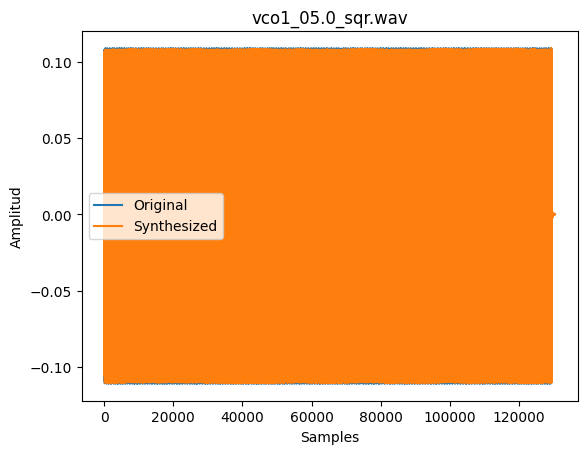

Similitud Coseno MFCC: 0.9906
Comparacion espectros: 0.9999952572791625
Similitud MSE: 0.0


In [24]:
filepath = 'test.json'

name, fund_freq, sampleRate, frameSize, hopSize, mags, freqs, phases, res = readJSON(filepath)

print('mags: ', np.shape(mags))
print('freqs: ', np.shape(freqs))
print('phases: ', np.shape(phases))
print('res: ', np.shape(res))

outsignal = audioSynthesis(sampleRate, frameSize, hopSize, mags, freqs, phases, res)
#cargar audio y valor de sample rate
audio, sampleRate = librosa.load(input_file, sr=sampleRate)
plt.xlabel('Samples')
plt.ylabel('Amplitud')
plt.plot(audio, label='Original')
plt.plot(outsignal, label='Synthesized')
plt.legend()
plt.title(name)
plt.show()
ipd.display(ipd.Audio(data=audio, rate=sampleRate))
ipd.display(ipd.Audio(data=outsignal, rate=sampleRate))


# COMPARACIONES ENTRE AUDIOS
#FUNCION DE SIMILITUD - MFCC Y SMILITIUD COSENO
print('Similitud Coseno MFCC: ' + str(similitud_coseno_MFCC(audio, outsignal, sampleRate)))
print('Comparacion espectros: '+str(comparar_frecuencias(audio, outsignal, sampleRate)))
print('Similitud MSE: ' + str(compare_audio_MSE(audio, outsignal)))

## Similitud coseno MFCC de la misma nota entre los dos pluguins desarrollados

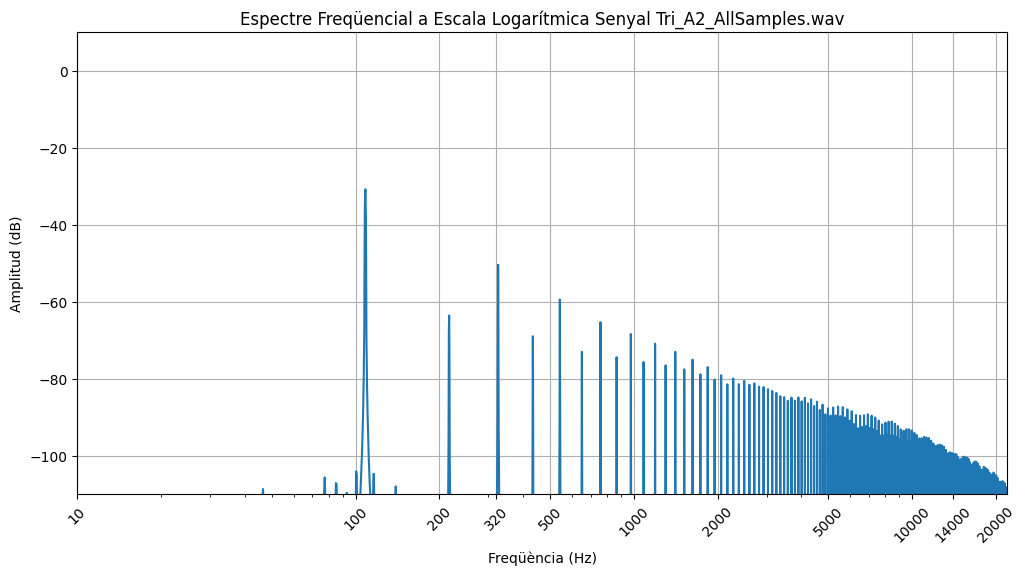

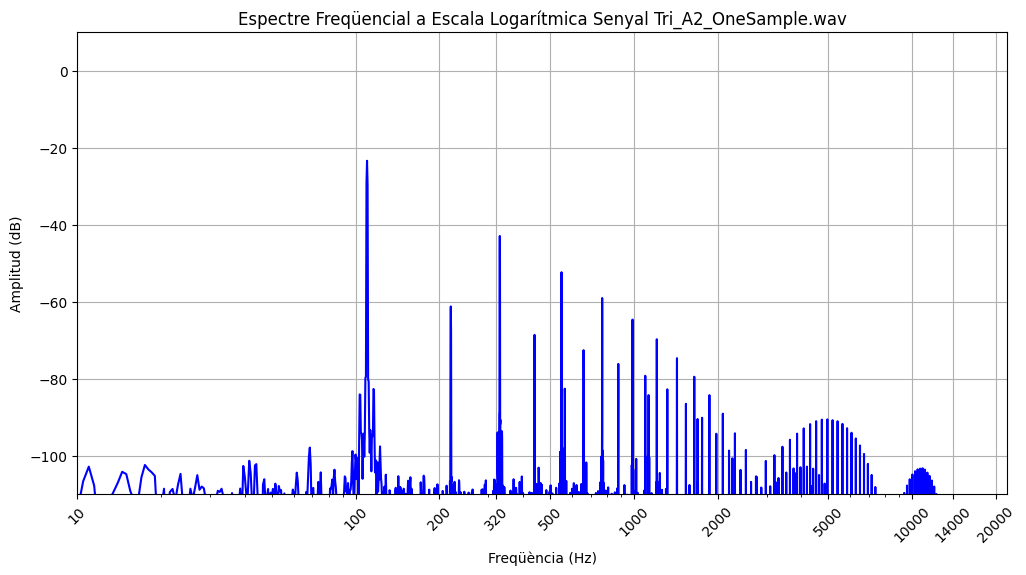

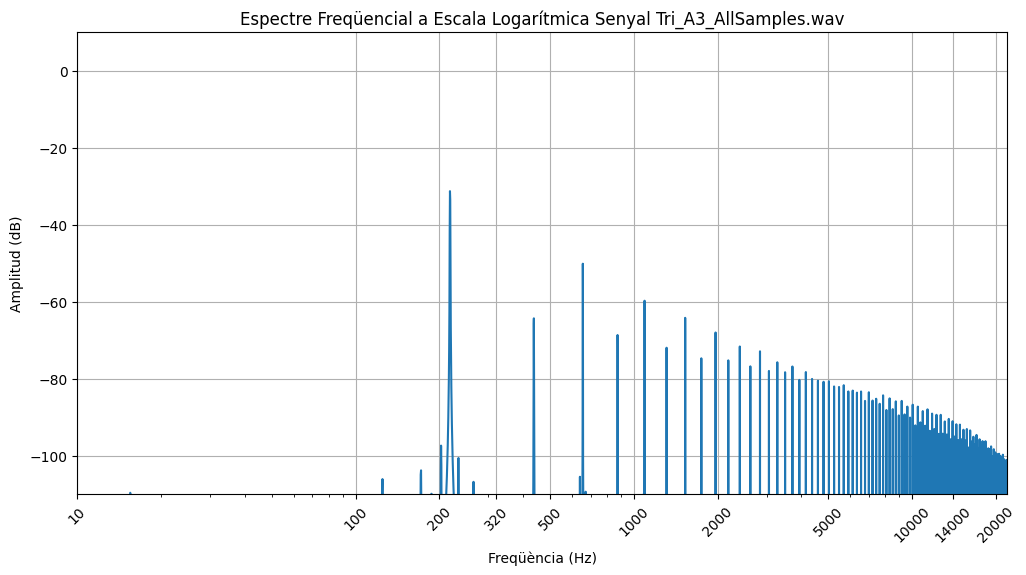

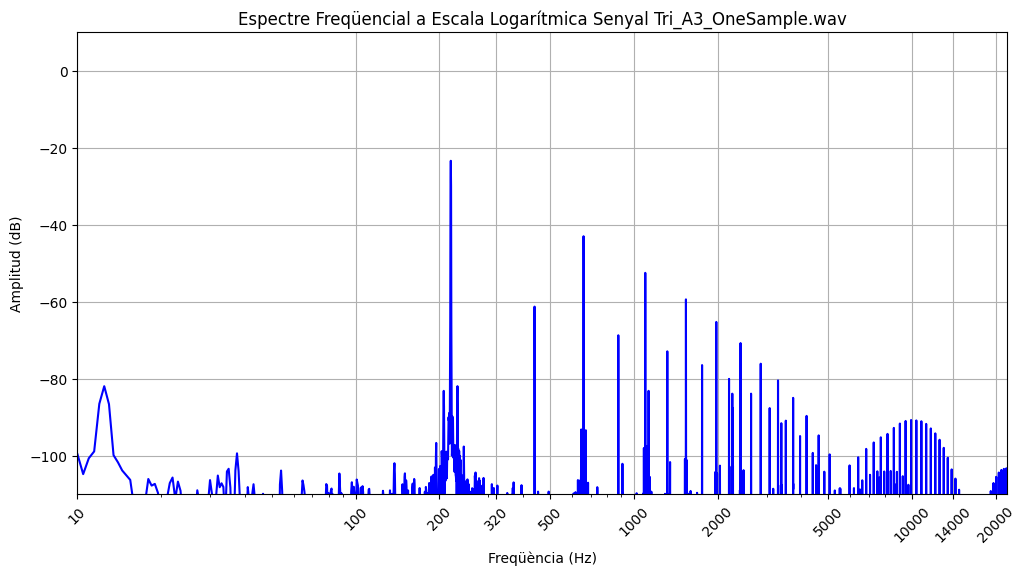

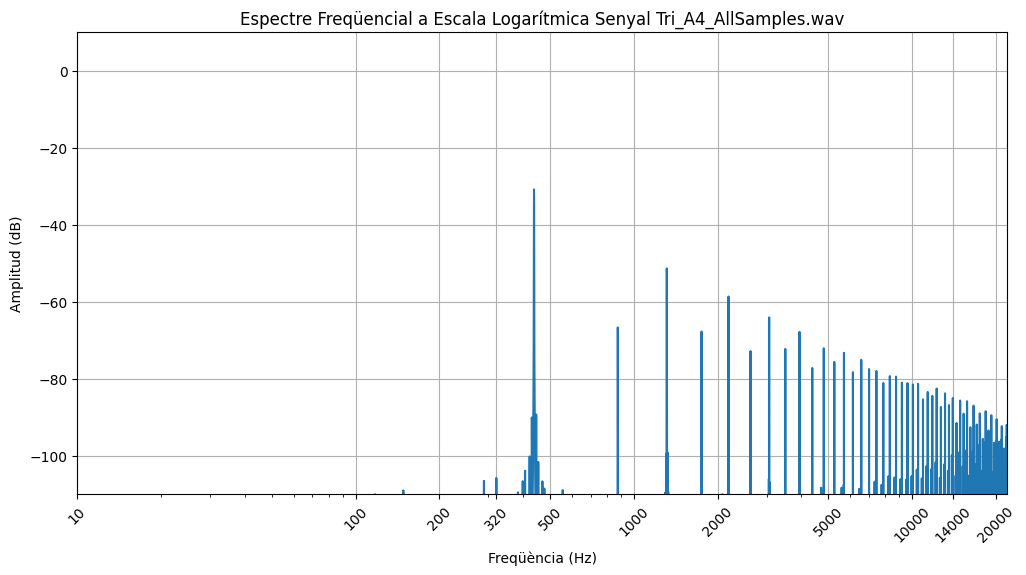

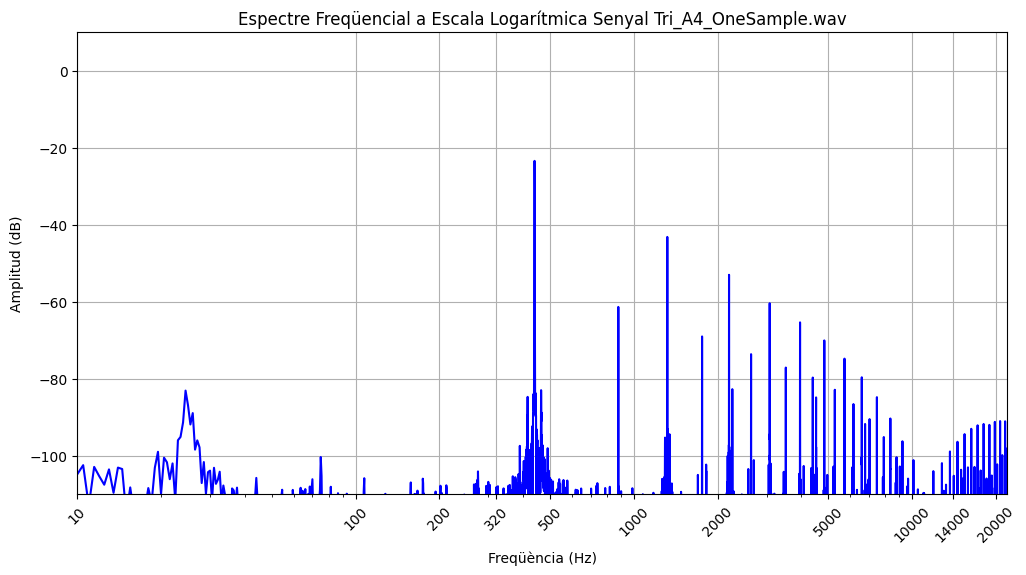

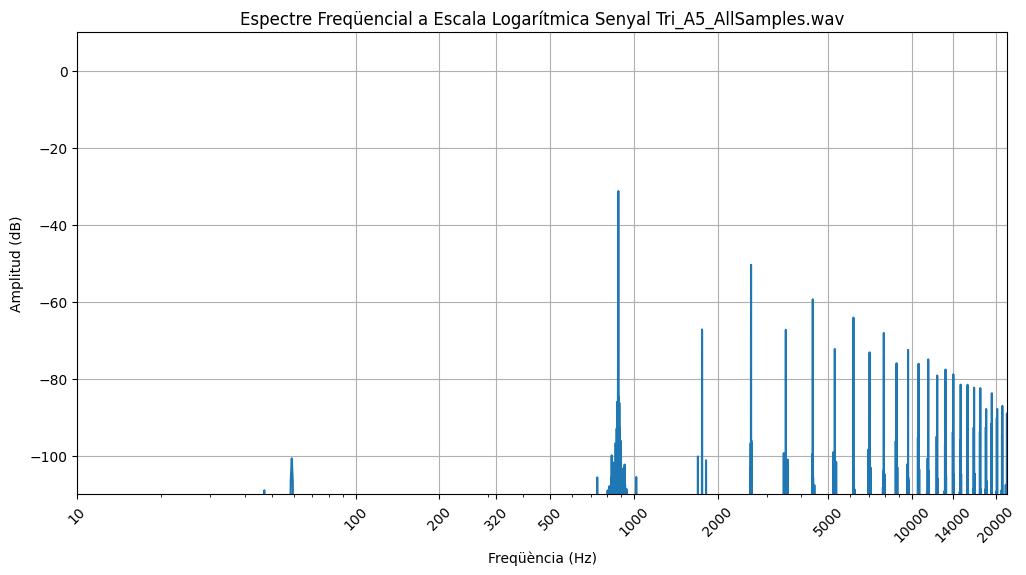

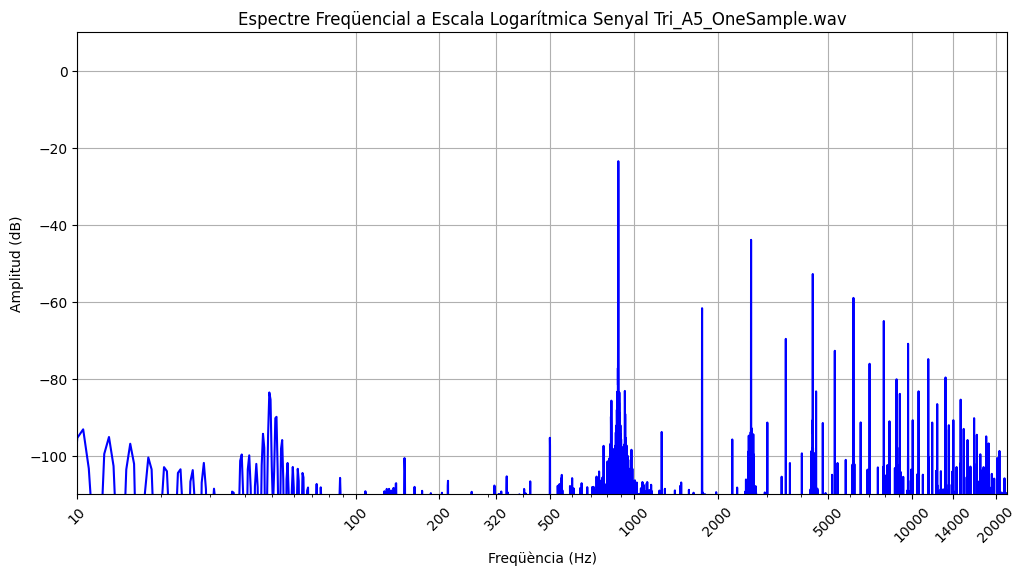

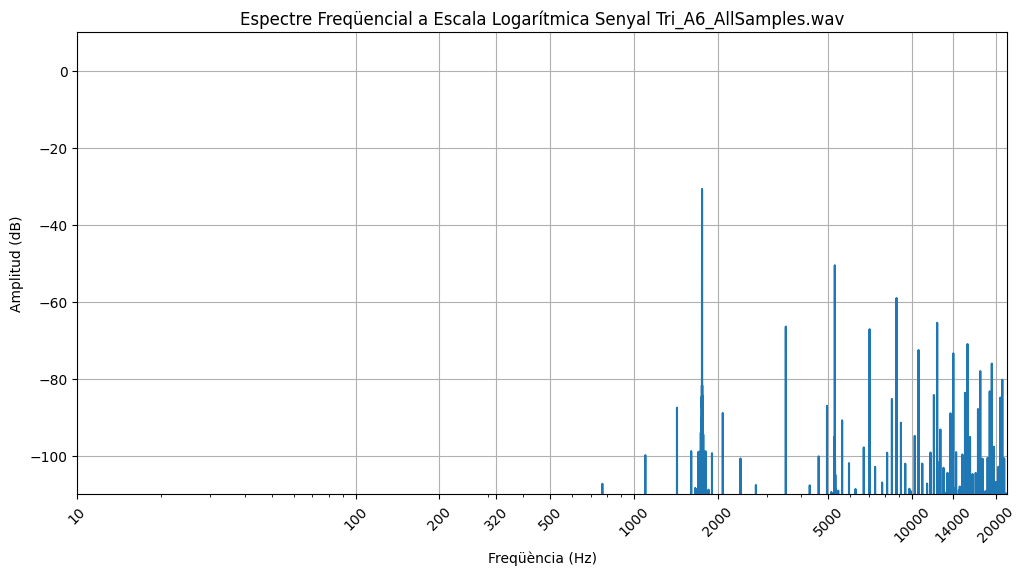

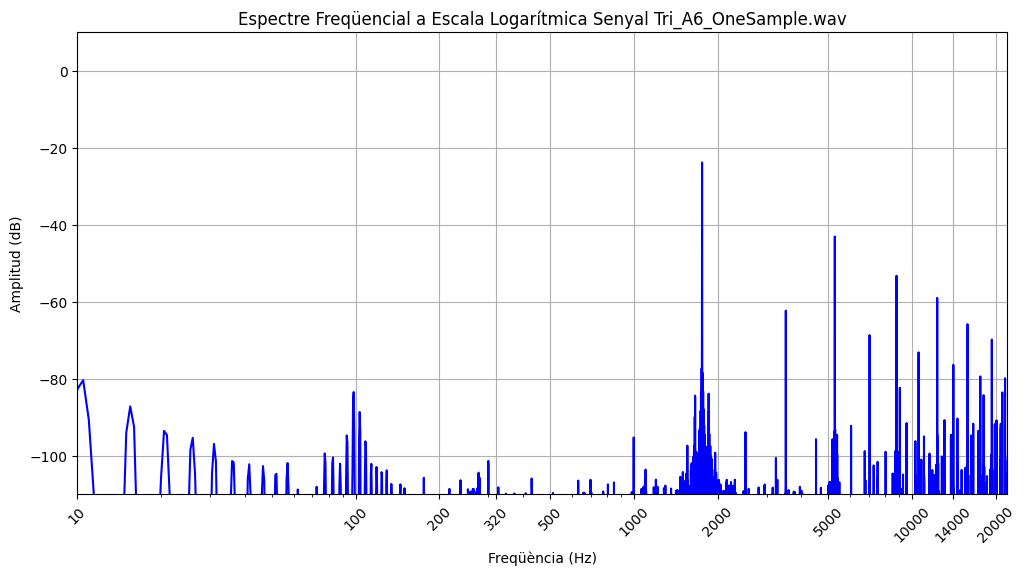

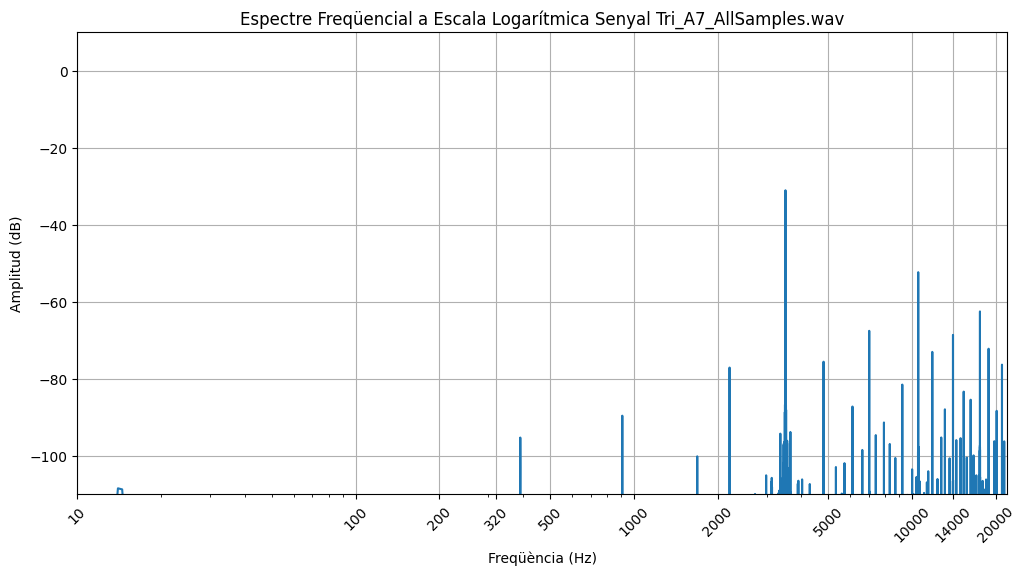

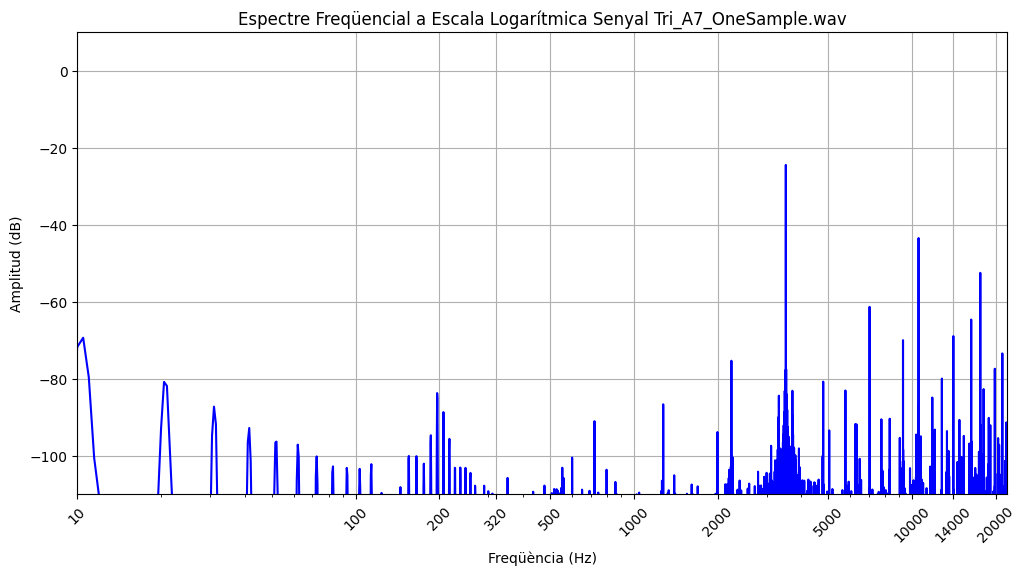

  Nota  Similitud MFCC  Similitud Espectros
0   A2          0.9255             0.997544
1   A3          0.8612             0.997983
2   A4          0.8155             0.996537
3   A5          0.8859             0.999599
4   A6          0.8751             0.999571
5   A7          0.8208             0.927201


In [15]:
# Directorio donde se encuentran los archivos de audio
audio_directory = '/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/Reaper_recs/'

# Lista de notas (C2, C3, C4, etc.)
notas = ["A2", "A3", "A4", "A5", "A6", "A7"]

# Lista para almacenar los resultados
resultados = []
sampleRate = 48000
# Iterar sobre las notas y calcular la similitud para cada par de archivos
for nota in notas:
    archivo_all_samples = os.path.join(audio_directory, f"Tri_{nota}_AllSamples.wav")
    archivo_one_sample = os.path.join(audio_directory, f"Tri_{nota}_OneSample.wav")
    
    if os.path.exists(archivo_all_samples) and os.path.exists(archivo_one_sample):
        # Cargar los archivos de audio
        audio1, sr1 = librosa.load(archivo_all_samples, sr=sampleRate)
        audio2, sr2 = librosa.load(archivo_one_sample, sr=sampleRate)
        
        # Calcular la similitud del coseno entre los coeficientes MFCC
        similitudMFCC = similitud_coseno_MFCC(audio1, audio2, sampleRate)
        similitudEspectros = comparar_frecuencias(audio1, audio2, sampleRate)
        
        plot_espectro_log(audio1, sampleRate, None, f"Tri_{nota}_AllSamples.wav")
        plot_espectro_log(audio2, sampleRate, None, f"Tri_{nota}_OneSample.wav", 'blue')

        # Agregar los resultados a la lista
        resultados.append({"Nota": nota,
                           "Similitud MFCC": similitudMFCC,
                           "Similitud Espectros": similitudEspectros})

# Crear el DataFrame a partir de la lista de resultados
df_resultados = pd.DataFrame(resultados)

# Imprimir los resultados
print(df_resultados)


## Comparativa de dos audios de la mateixa waveform a 1Volt de diferencia

In [13]:
input_file1 = '/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/pulse/vco1_05.0_pul-con.wav'
input_file2 = '/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/pulse/vco1_06.0_pul-con.wav'

audio1, sampleRate = librosa.load(input_file1, sr=48000)
audio2, sampleRate = librosa.load(input_file2, sr=48000)

print('Similitud Coseno MFCC: ' + str(similitud_coseno_MFCC(audio1, audio2, sampleRate)))
print('Comparacion espectros: '+str(comparar_frecuencias(audio1, audio2, sampleRate)))
print('Similitud MSE: ' + str(compare_audio_MSE(audio1, audio2)))

Similitud Coseno MFCC: 0.4754
Comparacion espectros: 0.3850674331188202
Similitud MSE: 0.007263


mags:  (923, 25)
freqs:  (923, 25)
phases:  (923, 25)
res:  (923, 128)


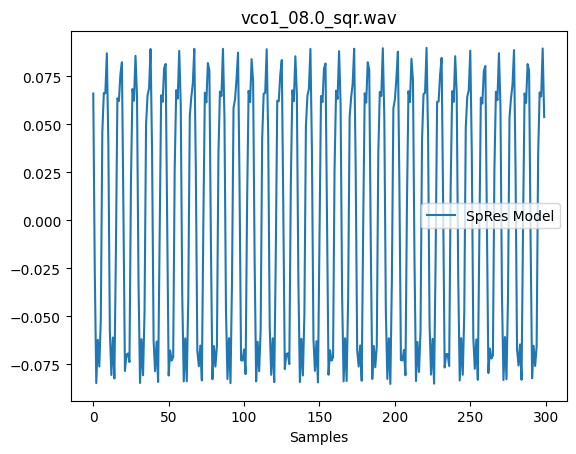

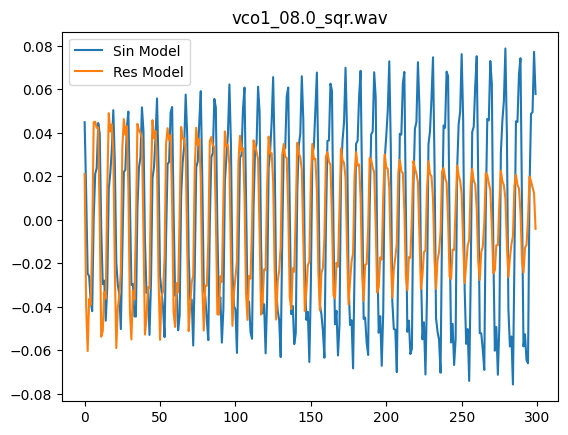

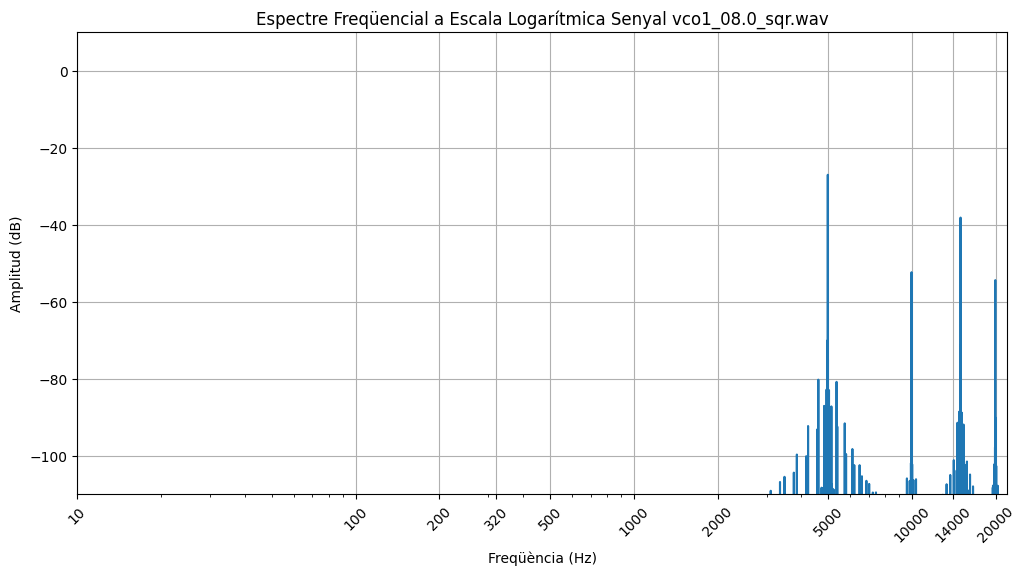

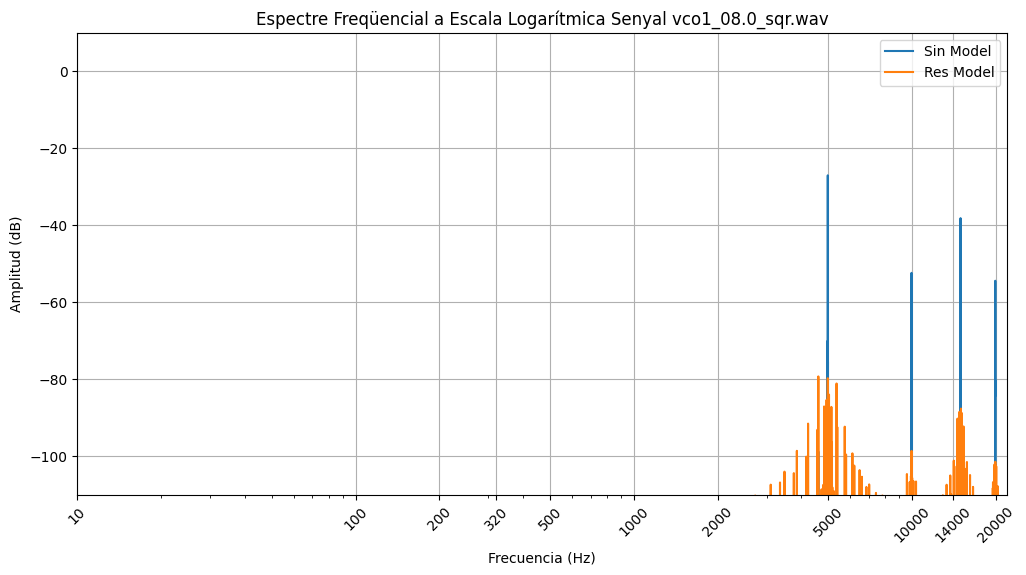

Original


SinePlusRes


Sine


Res


Error to signal ratio ORIGINAL & SINE: 0.0011185928552063264
Error to signal ratio OUTSIGNAL & SINE: 0.0013463285526832303


In [48]:
filepath = 'test.json'

name, fund_freq, sampleRate, frameSize, hopSize, mags, freqs, phases, res = readJSON(filepath)

print('mags: ', np.shape(mags))
print('freqs: ', np.shape(freqs))
print('phases: ', np.shape(phases))
print('res: ', np.shape(res))

outsignal, outsignal_sine, outsignal_res = audioSynthesis_SineAndRes(sampleRate, frameSize, hopSize, mags, freqs, phases, res)
labelSpRes='SpRes Model'
labelSin='Sin Model'
labelRes='Res Model'
#cargar audio y valor de sample rate
audio, sampleRate = librosa.load(input_file, sr=sampleRate)
plt.xlabel('Samples')
plt.plot(outsignal[:300], label=labelSpRes)
plt.legend()
plt.title(name)
plt.show()

plt.plot(outsignal_sine[:300], label=labelSin)
plt.title(name)
plt.plot(outsignal_res[:300], label=labelRes)
plt.title(name)
plt.legend()
plt.show()

plot_espectro_log(outsignal, sampleRate, labelSpRes, name)

fig = plt.figure(figsize=(12, 6)) # create a figure with custom size
plt.magnitude_spectrum(outsignal_sine, Fs=sampleRate, scale='dB', label=labelSin)
plt.magnitude_spectrum(outsignal_res, Fs=sampleRate, scale='dB', label=labelRes)
plt.title('Espectre Freqüencial a Escala Logarítmica Senyal ' + name)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud (dB)')
plt.grid()
plt.legend()
plt.xlim([10, 22000]) # set the limits of the x axis
plt.ylim([-110, 10]) # set the limits of the y axis
plt.xscale('log')
plt.xticks([10, 100, 200, 320, 500, 1000, 2000, 5000, 10000, 14000, 20000], 
           ["10", "100", "200","320", "500", "1000", "2000", "5000", "10000", "14000", "20000"], 
           rotation=45) # set the location of the tick marks on the x axis
plt.show()
print('Original')
ipd.display(ipd.Audio(data=audio, rate=sampleRate))
print('SinePlusRes')
ipd.display(ipd.Audio(data=outsignal, rate=sampleRate))
print('Sine')
ipd.display(ipd.Audio(data=outsignal_sine, rate=sampleRate))
print('Res')
ipd.display(ipd.Audio(data=outsignal_res, rate=sampleRate))

#print('Similitud MSE: ' + str(compare_audio_MSE(audio, outsignal_sine)))
print('Error to signal ratio ORIGINAL & SINE: ' + str(error_to_signal(audio, outsignal_sine[:np.shape(audio)[0]])))
print('Error to signal ratio OUTSIGNAL & SINE: ' + str(error_to_signal(outsignal, outsignal_sine)))

## *!Warning!*
## Generador de archivos JSON para todos los audios, en sus respectivas carpetas

In [25]:

path = '/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/' # Reemplazar con la ruta donde están las carpetas
file_list = [] # para almacenar los nombres de archivo


for folder in os.listdir(path):
    folder_path = os.path.join(path, folder) # ruta a cada carpeta
    for file in glob.glob(os.path.join(folder_path, '*.wav')): # busca todos los archivos con la extensión .audio_extension en cada carpeta
#         file_list.append(os.path.basename(file)) # agrega el nombre de archivo a la lista
        
        # carrgar todos los audios y dar audios para comparar
        fileAudio = os.path.basename(file)
        filepathAudio = folder_path + '/' + fileAudio
        print(filepathAudio)
        filepathJSON = filepathAudio.replace('rsf_kobol_expander_2-vco/audio/vco1', 'json_files')
        filepathJSON = filepathJSON.replace(".wav", ".json")
        print(filepathJSON)
        generateJSON(filepathJSON, filepathAudio, fileAudio)
        
        
        
#         outsignal = audioSynthesis(params, mags_list, freqs_list, phases_list, res_list)
        
#         loader = std.MonoLoader(filename = str(filepathAudio), sampleRate=params["sampleRate"])
#         audio = loader()
        
#         ipd.display(ipd.Audio(data=file, rate=params["sampleRate"]))
#         ipd.display(ipd.Audio(data=outsignal, rate=params["sampleRate"]))



print(file_list)

/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/pulse/vco1_00.0_pul-con.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/pulse/vco1_00.0_pul-con.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/pulse/vco1_00.5_pul-con.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/pulse/vco1_00.5_pul-con.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/pulse/vco1_01.0_pul-con.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/pulse/vco1_01.0_pul-con.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/pulse/vco1_01.5_pul-con.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/pulse/vco1_01.5_pul-con.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/pulse/vco1_02.0_pul-con.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-Bo

/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/sawtooth/vco1_09.5_saw.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/sawtooth/vco1_09.5_saw.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/sawtooth/vco1_10.0_saw.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/sawtooth/vco1_10.0_saw.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/sawtooth +/vco1_00.0_saw+-sqr.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/sawtooth +/vco1_00.0_saw+-sqr.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/sawtooth +/vco1_00.5_saw+-sqr.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/sawtooth +/vco1_00.5_saw+-sqr.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/sawtooth +/vco1_01.0_saw+-sqr.wav
/mnt/c/Users/bosc

/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/sawtooth-square/vco1_07.0_saw-sqr.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/sawtooth-square/vco1_07.0_saw-sqr.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/sawtooth-square/vco1_07.5_saw-sqr.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/sawtooth-square/vco1_07.5_saw-sqr.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/sawtooth-square/vco1_08.0_saw-sqr.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/sawtooth-square/vco1_08.0_saw-sqr.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/sawtooth-square/vco1_08.5_saw-sqr.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/sawtooth-square/vco1_08.5_saw-sqr.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/au

/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/square/vco1_04.0_sqr.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/square/vco1_04.0_sqr.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/square/vco1_04.5_sqr.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/square/vco1_04.5_sqr.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/square/vco1_05.0_sqr.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/square/vco1_05.0_sqr.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/square/vco1_05.5_sqr.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/square/vco1_05.5_sqr.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/square/vco1_06.0_sqr.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/square

/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/square-pulse/vco1_03.0_sqr-pul.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/square-pulse/vco1_03.0_sqr-pul.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/square-pulse/vco1_03.5_sqr-pul.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/square-pulse/vco1_03.5_sqr-pul.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/square-pulse/vco1_04.0_sqr-pul.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/square-pulse/vco1_04.0_sqr-pul.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/square-pulse/vco1_04.5_sqr-pul.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/square-pulse/vco1_04.5_sqr-pul.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/square-pulse/vc

/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/triangular/vco1_01.0_tri.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/triangular/vco1_01.0_tri.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/triangular/vco1_01.5_tri.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/triangular/vco1_01.5_tri.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/triangular/vco1_02.0_tri.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/triangular/vco1_02.0_tri.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/triangular/vco1_02.5_tri.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/triangular/vco1_02.5_tri.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/triangular/vco1_03.0_tri.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG

/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/triangular +/vco1_10.0_tri+.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/triangular +/vco1_10.0_tri+.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/triangular-sawtooth/vco1_00.0_tri-saw.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/triangular-sawtooth/vco1_00.0_tri-saw.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/triangular-sawtooth/vco1_00.5_tri-saw.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/triangular-sawtooth/vco1_00.5_tri-saw.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/triangular-sawtooth/vco1_01.0_tri-saw.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/triangular-sawtooth/vco1_01.0_tri-saw.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expan

/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/triangular-sawtooth +/vco1_06.5_tri-saw+.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/triangular-sawtooth +/vco1_06.5_tri-saw+.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/triangular-sawtooth +/vco1_07.0_tri-saw+.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/triangular-sawtooth +/vco1_07.0_tri-saw+.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/triangular-sawtooth +/vco1_07.5_tri-saw+.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/triangular-sawtooth +/vco1_07.5_tri-saw+.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/triangular-sawtooth +/vco1_08.0_tri-saw+.wav
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/triangular-sawtooth +/vco1_08.0_tri-saw+.json
/mnt/c/Users/bosco/Deskt

## *!Warning!*
## Generador de archivos WAV a partir de los perfiles harmonicos almacenados en los JSON

In [26]:
import os
import glob
import soundfile as sf

path = '/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/' # Reemplazar con la ruta donde están las carpetas

# Rutas donde almacenar los archivos de audio resultantes
pathSine = '/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_synthesis/sine/'
pathSinePlusRes = '/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_synthesis/sinePlusRes/'

for folder in os.listdir(path):
    folder_path = os.path.join(path, folder) # Ruta a cada carpeta
    for file in glob.glob(os.path.join(folder_path, '*.json')): # Busca todos los archivos con la extensión .json en cada carpeta
        fileJSON = os.path.basename(file)
        filepathJSON = folder_path + '/' + fileJSON
        print(filepathJSON)
        
        name, fund_freq, sampleRate, frameSize, hopSize, mags, freqs, phases, res = readJSON(filepathJSON)
        out, outSine, outRes = audioSynthesis_SineAndRes(sampleRate, frameSize, hopSize, mags, freqs, phases, res)
        
        # Guardar archivo out como WAV en la carpeta correspondiente
        output_path = os.path.join(pathSine, folder) # Carpeta para almacenar archivos out
        os.makedirs(output_path, exist_ok=True) # Crear carpeta si no existe
        output_file = os.path.join(output_path, os.path.splitext(fileJSON)[0] + '.wav') # Nombre de archivo WAV basado en el archivo JSON
        sf.write(output_file, out, sampleRate)
        
        # Guardar archivo outSine como WAV en la carpeta correspondiente
        output_path = os.path.join(pathSinePlusRes, folder) # Carpeta para almacenar archivos outSine
        os.makedirs(output_path, exist_ok=True) # Crear carpeta si no existe
        output_file = os.path.join(output_path, os.path.splitext(fileJSON)[0] + '.wav') # Nombre de archivo WAV basado en el archivo JSON
        sf.write(output_file, outSine, sampleRate)


/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/pulse/vco1_00.0_pul-con.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/pulse/vco1_00.5_pul-con.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/pulse/vco1_01.0_pul-con.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/pulse/vco1_01.5_pul-con.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/pulse/vco1_02.0_pul-con.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/pulse/vco1_02.5_pul-con.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/pulse/vco1_03.0_pul-con.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/pulse/vco1_03.5_pul-con.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/pulse/vco1_04.0_pul-con.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/pulse/vco1_04.5_pul-con.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/pulse/

/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/sawtooth-square +/vco1_00.0_saw-sqr+.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/sawtooth-square +/vco1_00.5_saw-sqr+.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/sawtooth-square +/vco1_01.0_saw-sqr+.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/sawtooth-square +/vco1_01.5_saw-sqr+.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/sawtooth-square +/vco1_02.0_saw-sqr+.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/sawtooth-square +/vco1_02.5_saw-sqr+.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/sawtooth-square +/vco1_03.0_saw-sqr+.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/sawtooth-square +/vco1_03.5_saw-sqr+.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/sawtooth-square +/vco1_04.0_saw-sqr+.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-Bosco

/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/square-pulse +/vco1_00.5_sqr-pul+.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/square-pulse +/vco1_01.0_sqr-pul+.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/square-pulse +/vco1_01.5_sqr-pul+.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/square-pulse +/vco1_02.0_sqr-pul+.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/square-pulse +/vco1_02.5_sqr-pul+.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/square-pulse +/vco1_03.0_sqr-pul+.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/square-pulse +/vco1_03.5_sqr-pul+.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/square-pulse +/vco1_04.0_sqr-pul+.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/square-pulse +/vco1_04.5_sqr-pul+.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/square-pu

/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/triangular-sawtooth +/vco1_00.0_tri-saw+.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/triangular-sawtooth +/vco1_00.5_tri-saw+.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/triangular-sawtooth +/vco1_01.0_tri-saw+.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/triangular-sawtooth +/vco1_01.5_tri-saw+.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/triangular-sawtooth +/vco1_02.0_tri-saw+.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/triangular-sawtooth +/vco1_02.5_tri-saw+.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/triangular-sawtooth +/vco1_03.0_tri-saw+.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/triangular-sawtooth +/vco1_03.5_tri-saw+.json
/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/json_files/triangular-sawtooth +/vco1_04.0_tri-saw+.json
/mnt/c/Use

## Calculo de la frecúencia fundamental y plots

01.0
40
Frequencia fund. del señal calculada: 36.41847099325689
Frequencia fund. del señal según la tabla: 40


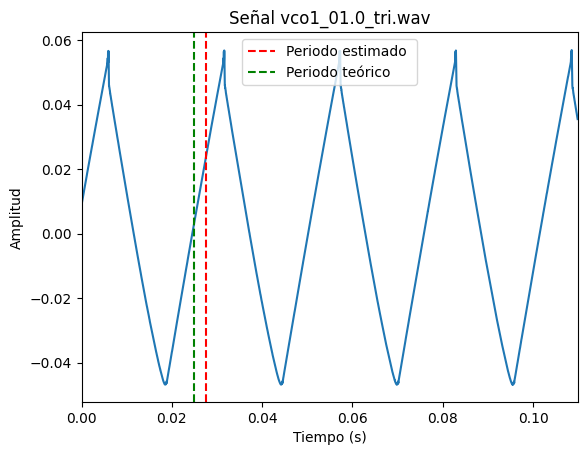

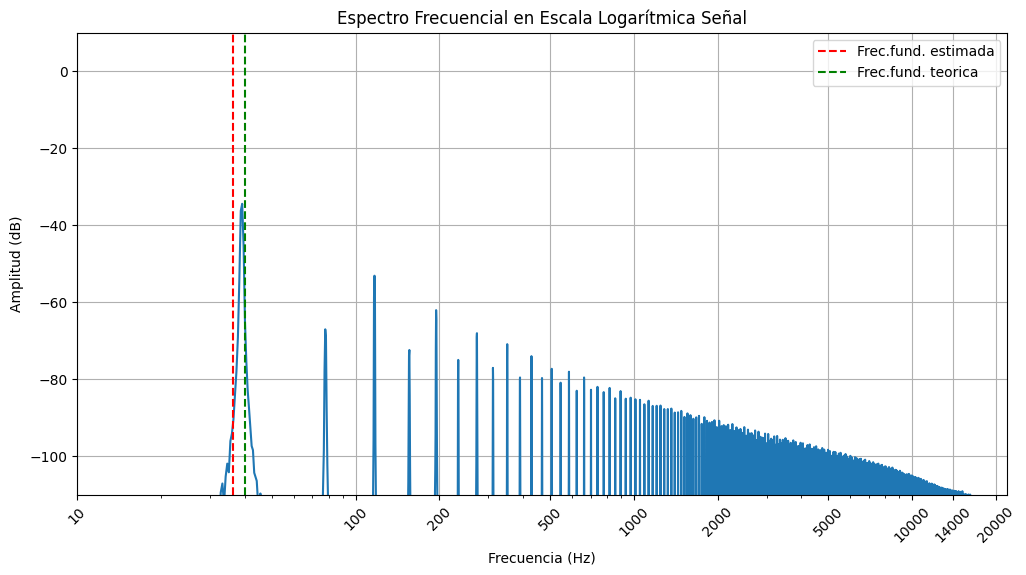

In [95]:
# input_file = '/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/sawtooth/vco1_1.0_saw.wav'
input_file = '/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/triangular/vco1_01.0_tri.wav'

file_name = input_file.split("/")[-1]

freq_fund_teorica = buscar_frecuencia(file_name)

audio, sampleRate = librosa.load(input_file, sr=48000)


# Realizar la transformada de Fourier
fft = np.fft.fft(audio)

# Obtener la amplitud de la transformada
magnitude = np.abs(fft)

# Obtener las frecuencias correspondientes
frequencies = np.fft.fftfreq(len(audio), 1/sampleRate)

# Encontrar la frecuencia fundamental
for i in range(len(magnitude)):
    if magnitude[i]>100:
        freq_fund_calculada = np.abs(frequencies[i])
        break

#Esta forma no siempre funciona ya que la frec. fundamental puede tenr un harmonico de mayor magnitud que ella misma
# fundamental_freq = np.abs(frequencies[np.argmax(magnitude)])


# Calcular el periodo estimado
period = 1 / freq_fund_calculada

period = np.abs(period)


print('Frequencia fund. del señal calculada: ' + str(freq_fund_calculada))
print('Frequencia fund. del señal según la tabla: ' + str(freq_fund_teorica))

# Calcular la duración total de la señal
total_time = len(audio) / sampleRate

# Definir los límites del eje x como un rango que cubra 4 veces el período
x_lim = [0, 4 * period]

# Realizar el plot de la señal
plt.plot(np.arange(len(audio)) / sampleRate, audio)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal ' + file_name)
plt.axvline(x=period, color='r', linestyle='--', label='Periodo estimado ') #segun tabla actualizada
period_theoric = 1/freq_fund_teorica


plt.axvline(x=period_theoric, color='g', linestyle='--', label='Periodo teórico')

plt.legend()
plt.xlim(x_lim)
plt.show()


# Ejemplo de como visualizar  el espectro y marcar la freq. fundamental

def plot_espectro_log(audio, sr, ffteorica, ffestimada):

    fig = plt.figure(figsize=(12, 6)) # create a figure with custom size
    
    plt.magnitude_spectrum(audio, Fs=sr, scale='dB')
    plt.title('Espectro Frecuencial en Escala Logarítmica Señal')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Amplitud (dB)')
    plt.grid()
    plt.xlim([10, 22000]) # set the limits of the x axis
    plt.ylim([-110, 10]) # set the limits of the y axis
    plt.xscale('log')
    plt.xticks([10, 100, 200, 500, 1000, 2000, 5000, 10000, 14000, 20000], 
               ["10", "100", "200", "500", "1000", "2000", "5000", "10000", "14000", "20000"], 
               rotation=45) 
    plt.axvline(x=ffestimada, color='r', linestyle='--', label='Frec.fund. estimada')
    plt.axvline(x=ffteorica, color='g', linestyle='--', label='Frec.fund. teorica')
    plt.legend()

    
    plt.show()
    
plot_espectro_log(audio, sampleRate, freq_fund_teorica, freq_fund_calculada)

# Autocorrelación del primer periodo con el segundo periodo

(1200,)
(1200,)


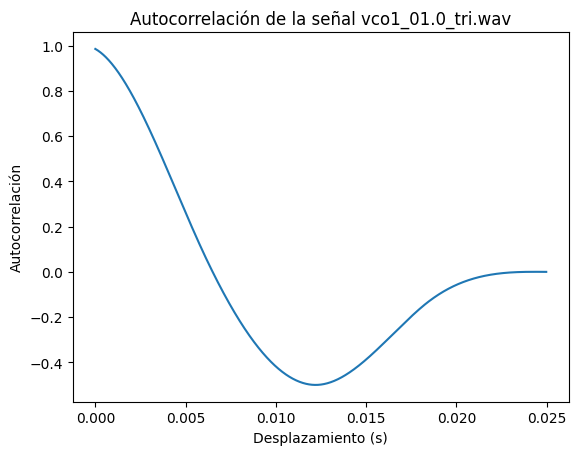

In [96]:
# Calcular el periodo estimado en muestras
period_duration = int(sampleRate / freq_fund_teorica)

# Obtener el primer periodo
primer_periodo = audio[:period_duration]
segundo_periodo = audio[period_duration:period_duration*2]
print(primer_periodo.shape)
print(segundo_periodo.shape)
# Calcular la autocorrelación del primer periodo con el segundo periodo
autocorrelacion = np.correlate(primer_periodo, segundo_periodo, mode='full')

# Normalizar la autocorrelación
autocorrelacion = autocorrelacion[period_duration-1:] / np.max(autocorrelacion)
# Plotear la autocorrelación
plt.plot(np.arange(0, len(autocorrelacion)) / sampleRate, autocorrelacion)
plt.xlabel('Desplazamiento (s)')
plt.ylabel('Autocorrelación')
plt.title('Autocorrelación de la señal ' + file_name)
plt.show()

# Autocorrelación del primer periodo con los siguientes 10 periodos

(105441,)


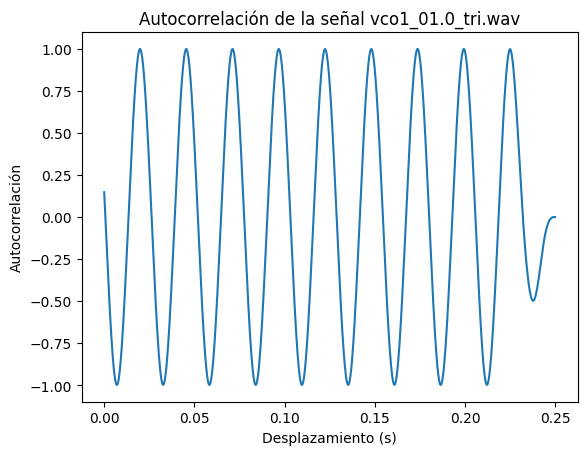

In [97]:

# Calcular el periodo estimado en muestras
period_duration = int(sampleRate / freq_fund_teorica)

# Obtener el primer periodo
print(audio.shape)
primer_periodo = audio[:period_duration]

audio_10_period = audio[:period_duration*10]

# Calcular la autocorrelación del primer periodo con el resto de periodos
autocorrelacion = np.correlate(primer_periodo, audio_10_period, mode='full')

# Normalizar la autocorrelación
autocorrelacion = autocorrelacion[period_duration-1:] / np.max(autocorrelacion)

# Plotear la autocorrelación
plt.plot(np.arange(0, len(autocorrelacion)) / sampleRate, autocorrelacion)
plt.xlabel('Desplazamiento (s)')
plt.ylabel('Autocorrelación')
plt.title('Autocorrelación de la señal ' + file_name)
plt.show()

# 
# 
# 
# 
# 
# 
#### Funciones en desuso

In [ ]:
def cut_audio_x_periods(audio, sampleRate, file_name):
    
    #obtener versión del audio de solo X periodos

    freq_fund_teorica = buscar_frecuencia(file_name)

    # Realizar la transformada de Fourier
    fft = np.fft.fft(audio)

    # Obtener la amplitud de la transformada
    magnitude = np.abs(fft)
    f0 = librosa.yin(audio,
                     sr=sampleRate, 
                     fmin=round(freq_fund_teorica/2), 
                    fmax= round(freq_fund_teorica + (freq_fund_teorica/2)),
                    trough_threshold=0.3)
    freq_fund_calculada = round(f0[-1])
    #print('Frequencia fund. del señal calculada: ' + str(freq_fund_calculada))
    #print('Frequencia fund. del señal según la tabla: ' + str(freq_fund_teorica))

    #Esta forma no siempre funciona ya que la frec. fundamental puede tenr un harmonico de mayor magnitud que ella misma
    # fundamental_freq = np.abs(frequencies[np.argmax(magnitude)])

    # calcular la duración de un periodo en SEGUNDOS i SAMPLES
    period = np.abs(1/freq_fund_teorica)
    period_samples = int(period*sampleRate)

    # Calcular el número de períodos actuales en el audio
    num_periods = int(len(audio) / period_samples)
    #print('Numero de periodos total del audio original: '+ str(num_periods))
    #obtener versión del audio de solo X periodos
    periods = int(num_periods/10)
    #print('Numero de periodos utilizados para el analisis: '+ str(periods))

    audio_cut = audio[:period_samples*periods]

    return audio_cut, freq_fund_calculada